#### Summary of data cleaning for statistical analysis<br>
<b>Data Description:</b>  There are 2 files for this project, described as identical except for the "class" column in each.  <br> One file classifies the measurements into 1) normal and 2) abnormal, while the second file categorizes more deeply into 1) normal, 2) hernia, and 2) spondylolisthesis.<br>
<b>Confirmation of description:</b>  Exploration confirms the files appear to be identical.  The columns are the same, the number of unique values and total values are the same, and the mean & standard deviations of the values are the same, except for abnormal values in 'class', which, as expected, has the "abnormal" values of the one file, categorized into "hernia", and "spondylolishesis" in the other file.<br>
<b>Null Values:</b>  There are no null values, if there were I would have removed these records in this case.<br>
<b>Duplicates:</b>  No reason to address identical values for this case, they are actually expected for medical measurements and should be left.<br>
<b>Outlier's:</b>  Outlier's identified for any degree above 360 since we are working with a 2-dimensional space which does not have >360 degrees and removed after merging files for ease-of-use<br>
<br>
<br>

The initial exploration summary follows the data cleaning below....\*


In [3]:
#  Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Read first file in and print description
classify = pd.read_csv('weka2c.csv')
classify.describe()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [5]:
# Read second file in and print description - compare to first for expected matching values
category = pd.read_csv('weka3c.csv')
category.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [6]:
# Review first file for uniqueness
print(classify.nunique())

pelvic_incidence            310
pelvic_tilt numeric         310
lumbar_lordosis_angle       280
sacral_slope                281
pelvic_radius               310
degree_spondylolisthesis    310
class                         2
dtype: int64


In [7]:
# Revies and compare second file to first
print(category.nunique())

pelvic_incidence            310
pelvic_tilt                 310
lumbar_lordosis_angle       280
sacral_slope                281
pelvic_radius               310
degree_spondylolisthesis    310
class                         3
dtype: int64


In [8]:
# Review the "class" column in the first file
classify["class"].value_counts()

Abnormal    210
Normal      100
Name: class, dtype: int64

In [9]:
# Review the "class" column in the second file - note the differences with the first
# Also note they have the  same number of "Normal" values, we expect these to be identical
category["class"].value_counts()

Spondylolisthesis    150
Normal               100
Hernia                60
Name: class, dtype: int64

In [34]:
#  Merge the files and rename the columns for ease-of-use
#  Note from now on the only separation of the 2 files is the 2 columns "category" and "class"
df = pd.merge(category, classify, on='degree_spondylolisthesis', how='right')
df2 = df[['pelvic_incidence_x', 'pelvic_tilt', 'lumbar_lordosis_angle_x', 'sacral_slope_x', 'pelvic_radius_x', 'degree_spondylolisthesis','class_x','class_y']]
df = df2.rename(columns = {'pelvic_incidence_x':'incidence', 'pelvic_tilt': 'tilt', 'lumbar_lordosis_angle_x': 'angle', 'sacral_slope_x': 'slope', 'pelvic_radius_x': 'radius', 'degree_spondylolisthesis' : 'degree', 'class_x' : 'category', 'class_y':'class'})
print(df.head())

   incidence       tilt      angle      slope      radius     degree category  \
0  63.027818  22.552586  39.609117  40.475232   98.672917  -0.254400   Hernia   
1  39.056951  10.060991  25.015378  28.995960  114.405425   4.564259   Hernia   
2  68.832021  22.218482  50.092194  46.613539  105.985135  -3.530317   Hernia   
3  69.297008  24.652878  44.311238  44.644130  101.868495  11.211523   Hernia   
4  49.712859   9.652075  28.317406  40.060784  108.168725   7.918501   Hernia   

      class  
0  Abnormal  
1  Abnormal  
2  Abnormal  
3  Abnormal  
4  Abnormal  


In [35]:
# slice and plot "normal" data from both the category and class
classified = df.loc[df['class'] == 'Normal']['degree']
categorized = df.loc[df['category'] == 'Normal']['degree']

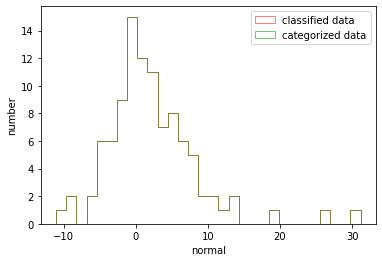

In [36]:
# The plot shows all lines in brown, indicating both data points overlap
# Note this is a nice confirmation that the data is as expected, the normal values for both match.
_ = plt.hist(classified, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'classified data')
_ = plt.hist(categorized, histtype = 'step', bins=30, alpha=0.5, color ='green', label = 'categorized data')
_ = plt.xlabel("normal")
_ = plt.ylabel("number")
_ = plt.legend()

In [37]:
# slice and plot "abnormal" data from both the category and class
classified = df.loc[df['class'] == 'Abnormal']['degree']
categorized = df.loc[df['category'] != 'Normal']['degree']

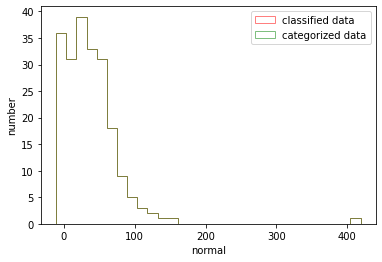

In [38]:
# The plot shows all lines in brown, indicating both data points overlap
# Note we see values > 360 
_ = plt.hist(classified, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'classified data')
_ = plt.hist(categorized, histtype = 'step', bins=30, alpha=0.5, color ='green', label = 'categorized data')
_ = plt.xlabel("normal")
_ = plt.ylabel("number")
_ = plt.legend()

In [39]:
# remove the ouliers, values > 360
df = df.loc[df['degree'] <= 360]

#### Analysis <br>


In [40]:
# slice and plot "abnormal" data from both the category and class
classified = df.loc[df['class'] == 'Abnormal']['degree']
hernia = df.loc[df['category'] == 'Hernia']['degree']
spondylolisthesis = df.loc[df['category'] == 'Spondylolisthesis']['degree']

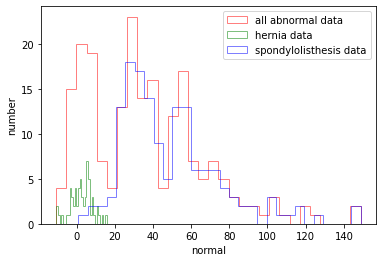

In [41]:
# The plot overlaps the abnormal (red) from one file with categorized (blue & green)
# Note we see hernia patients have less degree of spondylolisthesis but still overlap
_ = plt.hist(classified, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'all abnormal data')
_ = plt.hist(hernia, histtype = 'step', bins=30, alpha=0.5, color ='green', label = 'hernia data')
_ = plt.hist(spondylolisthesis, histtype = 'step', bins=30, alpha=0.5, color ='blue', label = 'spondylolisthesis data')
_ = plt.xlabel("normal")
_ = plt.ylabel("number")
_ = plt.legend()

### Below we see normal in red overlaps the abnormal values in green.  The degree of sponsylolesthesis is not a single measurement for determining normal vs abnormal values.  The rest of the features are graphed below and we can see correlation patterns.

(array([39., 30., 50., 32., 29., 15.,  5.,  4.,  3.,  2.]),
 array([-10.67587083,   5.26708734,  21.21004552,  37.15300369,
         53.09596186,  69.03892004,  84.98187821, 100.92483638,
        116.86779455, 132.81075273, 148.7537109 ]),
 [<matplotlib.patches.Polygon at 0x1ab1b01be08>])

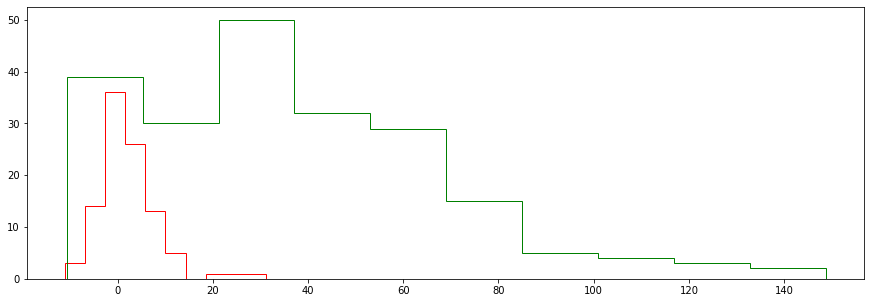

In [51]:
normal = df[df['class'] == 'Normal']['degree']
abnormal = df[df['class'] == 'Abnormal']['degree']

plt.figure(figsize=[15,5])
plt.hist(normal, histtype='step', color = 'red')
plt.hist(abnormal, histtype='step', color = 'green')

from the above figure we see what could be an outlier >360 degrees, upon consultation with physician it is suggested an adjustment should be made by subtracting 360 degrees from the reading.  Without knowing more I've decided to remove the value as a potential outlier and continue without this reading.

In [54]:
df = df.loc[df['degree'] < 35]
df = df.loc[df[df = df.loc[df['degree'] < 35]] > 1]
hernia = df[df.class_x == 'Hernia'][df = df.loc[df['degree'] < 35]
']
Spondylolisthesis = df[df.class_x == 'Spondylolisthesis'][df = df.loc[df['degree'] < 35]
']
normal = df[df.class_x == 'Normal'][df = df.loc[df['degree'] < 35]
']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

SyntaxError: invalid syntax (<ipython-input-54-c7e2acee3ba9>, line 2)

In [ ]:
df3 = df2.copy(deep=True)
df3 = df3.loc[df3['degree_spondylolisthesis'] < 20]
df3 = df3[['pelvic_incidence_y', 'class_x']]
hernia = df3[df3.class_x == 'Hernia']['pelvic_incidence_y']
Spondylolisthesis = df3[df3.class_x == 'Spondylolisthesis']['pelvic_incidence_y']
normal = df3[df3.class_x == 'Normal']['pelvic_incidence_y']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

In [ ]:
df3 = df2.copy(deep=True)
df3 = df3.loc[df3['degree_spondylolisthesis'] < 50]
df3 = df3[['sacral_slope_y', 'class_x']]
hernia = df3[df3.class_x == 'Hernia']['sacral_slope_y']
Spondylolisthesis = df3[df3.class_x == 'Spondylolisthesis']['sacral_slope_y']
normal = df3[df3.class_x == 'Normal']['sacral_slope_y']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

In [ ]:
df3 = df2.copy(deep=True)
df3 = df3.loc[df3['degree_spondylolisthesis'] < 50]
df3 = df3[['pelvic_radius_y', 'class_x']]
hernia = df3[df3.class_x == 'Hernia']['pelvic_radius_y']
Spondylolisthesis = df3[df3.class_x == 'Spondylolisthesis']['pelvic_radius_y']
normal = df3[df3.class_x == 'Normal']['pelvic_radius_y']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

In [ ]:
df3 = df2.copy(deep=True)
df3 = df3.loc[df3['degree_spondylolisthesis'] < 50]
df3 = df3[['lumbar_lordosis_angle_y', 'class_x']]
hernia = df3[df3.class_x == 'Hernia']['lumbar_lordosis_angle_y']
Spondylolisthesis = df3[df3.class_x == 'Spondylolisthesis']['lumbar_lordosis_angle_y']
normal = df3[df3.class_x == 'Normal']['lumbar_lordosis_angle_y']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

In [ ]:
df3 = df2.copy(deep=True)
df3 = df3.loc[df3['degree_spondylolisthesis'] < 50]
df3 = df3[['pelvic_tilt numeric', 'class_x']]
hernia = df3[df3.class_x == 'Hernia']['pelvic_tilt numeric']
Spondylolisthesis = df3[df3.class_x == 'Spondylolisthesis']['pelvic_tilt numeric']
normal = df3[df3.class_x == 'Normal']['pelvic_tilt numeric']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

From the above exploratinos I would pretty much ignore pelvic tilt as a feature, it is distributed almost identically as the normal.

However, we can see the lumbar lardosis angle is increased for spondylolesthesis while pelvic radius is decreased.  If these two measurements were weighted, value for the pelvic radius less than 140 with lumbar lardosis angle's greater than 40 could be weighted with a higher probability for spondylolesthesis and vice versa.

To separate out the herniated disc I would weight values for increased lumbar lardosis not as muc as for spondylolesthesis and decreased pelvic radius but 

In [ ]:
df4 = df2.copy(deep=True)
df4 = df4.loc[df4['degree_spondylolisthesis'] < 50]

hernia = df4[df4.class_x == 'Hernia']

print(hernia)

#plt.figure(figsize=[15,5])
#plt.hist(hernia, histtype='step', color = 'red')



In [ ]:
#correlation map
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, linewidth=".5", cmap="RdPu", fmt=".2f", ax = ax)
plt.title("Correlation Map",fontsize=20)
plt.show()